In [1]:
using Compat, Random, Distributions, Plots, LinearAlgebra, Statistics, LaTeXStrings, SparseArrays, CPUTime, JLD2
using SpecialFunctions, GSL, SuiteSparse, Distributed, Roots
gr(fmt=:png)
e = 2.7182818284
Random.seed!(1);

In [2]:
addprocs(2)
@everywhere using Compat, Random, Distributions, Plots, LinearAlgebra, Statistics, LaTeXStrings, SparseArrays, CPUTime, JLD2, SpecialFunctions, GSL, SuiteSparse, Distributed
@everywhere using SharedArrays, ParallelDataTransfer, Roots, NBInclude
@everywhere @nbinclude("setup.ipynb")
@everywhere using .setup, .ss_functions
@load "parameters.jld2"
procs()

3-element Vector{Int64}:
 1
 2
 3

Options for calculating the steady state:

* baseline productivity differences: productivity in non-tradables is 0.6 of that in tradables
* equal productivities
* productivities switched: productivity in tradables is 0.6 of that in non-tradables

Choose *productivity_gap* from mutually exclusive "**baseline**", "**equal**", "**switched**" (uncomment the relevant one):

In [3]:
productivity_gap = "baseline"
#productivity_gap = "equal"
#productivity_gap = "switched"

"baseline"

In [4]:
# loading parameters
if productivity_gap == "baseline"
    @load "external_parameters.jld2"
elseif productivity_gap == "equal"
    @load "external_parameters_equal.jld2"
elseif productivity_gap == "switched"
    @load "external_parameters_switched.jld2"
end

6-element Vector{Symbol}:
 :prod_N
 :prod_T
 :export_share
 :NT_to_GDP
 :foreign_to_gdp
 :MPC_target

      From worker 3:	distance = 9.843921623064503e-10, 413 iterations
      From worker 3:	elapsed CPU time: 14.906 seconds
      From worker 2:	distance = 9.88422983671197e-10, 410 iterations
      From worker 2:	elapsed CPU time: 15.156 seconds
 30.425098 seconds (17.87 M allocations: 1016.940 MiB, 1.32% gc time, 18.46% compilation time)

total sales: 0.19264 = 0.15527 (consumption) + 0.03737 (gov. expenditures);
sales of tradables: 0.10421; sales of non-tradables: 0.08843; trade balance: 0.00085;
sales of imports: 0.04055; sales of domestic tradables: 0.06366; exports: 0.04141;
debt: 0.45686; debt to GDP: 19.676%

verify that ζ, α, and η are set correctly:
error on ζ: 0.0, error on η: 0.0, error on α: 0.0



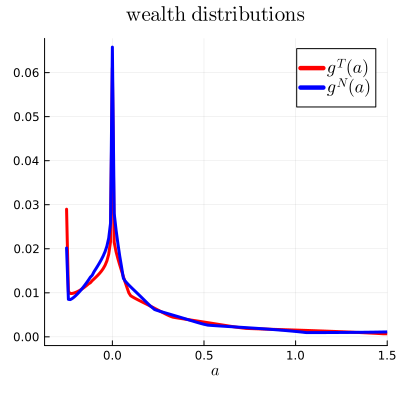

In [5]:
# initializing a guess for the value function
interest_init = map(q->interest(q,par),par_grid.assets)
value = log.(interest_init+par_grid.productivity*(1-par.τ_w)^(par.χ2+1)*par.χ1^(-par.χ2)) - par_grid.productivity*χ(((1-par.τ_w)/par.χ1)^par.χ2,par)

# computing the steady-state values, distributions, consumption, and labor
par_grid_T, par_grid_N = deepcopy(par_grid), deepcopy(par_grid)
par_grid_N.productivity, par_grid_N.labor = prod_N*par_grid_N.productivity, prod_N*par_grid_N.labor
par_grid_T.productivity, par_grid_T.labor = prod_T*par_grid_T.productivity, prod_T*par_grid_T.labor
@time paral = pmap(solve_workers,[value,value],[1-par.τ_w,1-par.τ_w],[par,par],[par_grid_T,par_grid_N])
distr_T, value_T, cons_T, c_quarter_T, c_year_T, labor_vec_T, labor_supply_T, dist_T = paral[1]
distr_N, value_N, cons_N, c_quarter_N, c_year_N, labor_vec_N, labor_supply_N, dist_N = paral[2]

# computing the steady-state values of other variables

if productivity_gap != "baseline"
    par.ζ_N = NT_to_GDP*labor_supply_T/(NT_to_GDP*labor_supply_T + (1-NT_to_GDP)*labor_supply_N)
    par.ζ_T = 1 - par.ζ_N
end
GDP = labor_supply_T * par.ζ_T + labor_supply_N * par.ζ_N
assets_to_gdp = par_grid.assets'*(distr_T*par.ζ_T+distr_N*par.ζ_N)/12/GDP
loan_arbitrage = min.(par_grid.assets,0)'*(distr_T*par.ζ_T+distr_N*par.ζ_N) * (par.r_d-par.r_l)
consumption = cons_T'*distr_T * par.ζ_T + cons_N'*distr_N * par.ζ_N
foreign_share = foreign_to_gdp/(foreign_to_gdp+assets_to_gdp)
trade_balance = par.r_d*foreign_to_gdp*12*GDP
if productivity_gap != "baseline"
    par.η = 1 - NT_to_GDP/(1-trade_balance/GDP)
    par.α = (1-NT_to_GDP-export_share)/(1-trade_balance/GDP)/par.η
end
q_total = GDP-trade_balance
q_F = GDP*export_share-trade_balance
q_N = NT_to_GDP*GDP
q_T = par.η*q_total
q_H = par.α/(1-par.α)*q_F
q_E = GDP*export_share
debt = assets_to_gdp/(1-foreign_share)*12*GDP
debt_to_gdp = debt/GDP/12
interest_payments = par.r_d*debt
G = par.τ_w*GDP + loan_arbitrage - interest_payments
print("\ntotal sales: ",round(q_total,digits=5)," = ",round(consumption,digits=5)," (consumption) + ",round(G,digits=5)," (gov. expenditures);\n")
print("sales of tradables: ",round(q_T,digits=5),"; sales of non-tradables: ",round(q_N,digits=5),"; trade balance: ",round(par.r_d*foreign_to_gdp*12*GDP,digits=5),";\n")
print("sales of imports: ",round(q_F,digits=5),"; sales of domestic tradables: ",round(q_H,digits=5),"; exports: ",round(q_E,digits=5),";\n")
print("debt: ",round(debt,digits=5),"; debt to GDP: ",round(100*debt/GDP/12,digits=3),"%\n\n")

if productivity_gap == "baseline"
    print("verify that ζ, α, and η are set correctly:\n")
    print("error on ζ: ",par.ζ_N - NT_to_GDP*labor_supply_T/(NT_to_GDP*labor_supply_T + (1-NT_to_GDP)*labor_supply_N),", ")
    print("error on η: ",par.η - (1 - NT_to_GDP/(1-trade_balance/GDP)),", ")
    print("error on α: ",par.α - (1-NT_to_GDP-export_share)/(1-trade_balance/GDP)/par.η,"\n\n")
end

if productivity_gap != "baseline"
    print("recalibrate ζ, α, and η:\n")
    print("new ζ: ",round(par.ζ_T,digits=3),", ")
    print("new η: ",round(par.η,digits=3),", ")
    print("new α: ",round(par.α,digits=3),"\n\n")
end

plot_both_distr = plot(par_grid.q_grid,sum(reshape(distr_T,par_grid.N,par_grid.K),dims=2),color=:red,linewidth=3,label=L"g^T(a)",xlim=[par_grid.a_bar-0.12,1.5],xlabel=L"a")
plot!(par_grid.q_grid,sum(reshape(distr_N,par_grid.N,par_grid.K),dims=2),color=:blue,linewidth=3,label=L"g^N(a)",xlim=[par_grid.a_bar-0.12,1.5])
plot(plot_both_distr,legend=:topright,legendfontsize=12,title=L"\mathrm{wealth\ distributions}",size=(400,400))

In [18]:
if productivity_gap == "baseline"
    @save "steady_state_output.jld2" par par_grid q_N q_F q_H q_E q_T q_total G consumption debt loan_arbitrage distr_T value_T cons_T labor_supply_T distr_N value_N cons_N labor_supply_N c_quarter_T c_quarter_N
elseif productivity_gap == "equal"
    @save "steady_state_output_equal.jld2" par par_grid q_N q_F q_H q_E q_T q_total G consumption debt loan_arbitrage distr_T value_T cons_T labor_supply_T distr_N value_N cons_N labor_supply_N c_quarter_T c_quarter_N
elseif productivity_gap == "switched"
    @save "steady_state_output_switched.jld2" par par_grid q_N q_F q_H q_E q_T q_total G consumption debt loan_arbitrage distr_T value_T cons_T labor_supply_T distr_N value_N cons_N labor_supply_N c_quarter_T c_quarter_N
end